In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import PIL
import cv2
import random

from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow import keras

In [2]:
#Data Augmentation for Training and Validation
train_datagen = ImageDataGenerator(
    rescale = 1./255,
    rotation_range = 40,
    width_shift_range = 0.2,
    height_shift_range = 0.2,
    shear_range = 0.2,
    zoom_range = 0.2,
    brightness_range = [0.8, 1.2],
    horizontal_flip = True,
    validation_split = 0.3,
    fill_mode = 'nearest'
)

validation_datagen = ImageDataGenerator(
    rescale = 1./255,
    validation_split = 0.3
)

In [3]:
#Load the Dataset and call data augmentations

train_generator = train_datagen.flow_from_directory(
    'oversampled_dataset',
    target_size = (224, 224),
    batch_size = 16,
    class_mode = 'categorical',
    subset = 'training',
    shuffle = True,
    seed = 25
)

validation_generator = validation_datagen.flow_from_directory(
    'oversampled_dataset',
    target_size = (224, 224),
    batch_size = 16,
    class_mode = 'categorical',
    subset = 'validation',
    shuffle = True,
    seed = 25
)

y_train = train_generator.classes
y_val = validation_generator.classes

Found 776 images belonging to 8 classes.
Found 328 images belonging to 8 classes.


In [4]:
train_generator.class_indices
validation_generator.class_indices

{'Aratan': 0,
 'Flores': 1,
 'Harper': 2,
 'Ilogon': 3,
 'Malaluan': 4,
 'Matilla': 5,
 'Rasonabe': 6,
 'Tamayo': 7}

In [5]:
# Convert to tf.data.Dataset and add AUTOTUNE, shuffle, and prefetch
train_dataset = tf.data.Dataset.from_generator(
    lambda: train_generator,
    output_signature=(
        tf.TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32),
        tf.TensorSpec(shape=(None, train_generator.num_classes), dtype=tf.float32)
    )
)

validation_dataset = tf.data.Dataset.from_generator(
    lambda: validation_generator,
    output_signature=(
        tf.TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32),
        tf.TensorSpec(shape=(None, validation_generator.num_classes), dtype=tf.float32)
    )
)

# Apply shuffle and prefetch to the tf.data.Dataset
train_dataset = train_dataset.shuffle(100, seed = 25).prefetch(buffer_size=tf.data.AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=tf.data.AUTOTUNE)

In [6]:
from sklearn.utils.class_weight import compute_class_weight

class_weights = compute_class_weight(
    'balanced',
    classes=np.unique(y_train),
    y=y_train
)

In [7]:
from tensorflow.keras import Input
from tensorflow.keras.regularizers import l2

# Model Initialization
model = models.Sequential()

#Define the input shape using the input layer
model.add(Input(shape=(224, 224, 3)))

#Block 1
model.add(layers.Conv2D(32, (4, 4),strides = (2,2), activation = 'relu', padding = 'same')) #32
model.add(layers.BatchNormalization())
model.add(layers.Conv2D(64, (2, 2), activation = 'relu', padding = 'valid')) #64
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D((2, 2)))

#Block 2
model.add(layers.Conv2D(64, (5, 5), strides = (2,2),activation = 'relu', padding = 'same')) #64
model.add(layers.BatchNormalization())
model.add(layers.Conv2D(128, (3, 3),activation = 'relu', padding = 'valid')) #128
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D((2, 2)))

#Block 3
model.add(layers.Conv2D(256, (3, 3), activation = 'relu', padding = 'same')) #256
model.add(layers.BatchNormalization())
model.add(layers.Conv2D(512, (3, 3), activation = 'relu', padding = 'same')) #256
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D((2, 2)))

# Add fully connected layers
model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.Dense(512, activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(len(train_generator.class_indices), activation='softmax'))

In [8]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 112, 112, 32)        │           1,568 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 112, 112, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 111, 111, 64)        │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 111, 111, 64)        │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 55, 55, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 28, 28, 64)          │         102,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 28, 28, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 26, 26, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 26, 26, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 13, 13, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 13, 13, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 13, 13, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 13, 13, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (None, 13, 13, 512)         │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 6, 6, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 18432)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │       9,437,696 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_6                │ (None, 512)                 │           2,048 │
│ (BatchNormalization)                 │                             │              

 Total params: 11,374,248 (43.39 MB)

 Trainable params: 11,370,088 (43.37 MB)

 Non-trainable params: 4,160 (16.25 KB)

In [9]:
from tensorflow.keras.metrics import Precision

# Compile the model with precision as an additional metric
model.compile(optimizer='adam',
              loss=keras.losses.CategoricalFocalCrossentropy(),
              metrics=['accuracy', 'precision'])

In [10]:
# Train the model with the tf.data.Dataset objects
history = model.fit(
    train_dataset,
    epochs=100,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    validation_data=validation_dataset,
    validation_steps=validation_generator.samples // validation_generator.batch_size,
    class_weight=dict(enumerate(class_weights)),
)

Epoch 1/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 71s 697ms/step - accuracy: 0.2142 - loss: 0.7210 - precision: 0.2483 - val_accuracy: 0.1281 - val_loss: 0.6294 - val_precision: 0.1376
Epoch 2/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 27s 560ms/step - accuracy: 0.2658 - loss: 0.5154 - precision: 0.3244 - val_accuracy: 0.1410 - val_loss: 1.0570 - val_precision: 0.1631
Epoch 3/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 27s 564ms/step - accuracy: 0.3023 - loss: 0.4621 - precision: 0.3570 - val_accuracy: 0.1506 - val_loss: 0.5839 - val_precision: 0.0588
Epoch 4/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 27s 562ms/step - accuracy: 0.3502 - loss: 0.4298 - precision: 0.4159 - val_accuracy: 0.1795 - val_loss: 0.8627 - val_precision: 0.1784
Epoch 5/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 27s 570ms/step - accuracy: 0.3632 - loss: 0.3939 - precision: 0.4247 - val_accuracy: 0.1346 - val_loss: 1.1039 - val_precision: 0.1405
Epoch 6/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 30s 620ms/step - accuracy: 0.3730 - loss: 0.4060 - precision: 0.4629 - val_accuracy: 0.1891

In [11]:
# Save the trained model
model.save('facial_recognition_model.keras')

In [12]:
import matplotlib.pyplot as plt

def plot_training_metrics(history, save_path='training_metrics.png'):
    """
    Plots accuracy, precision, and loss for both training and validation, and saves the plot to a file.
    
    Args:
    history: A Keras History object that contains the training/validation accuracy, 
             precision, and loss for each epoch.
    save_path: Path to save the plot image. Default is 'training_metrics.png'.
    """
    # Retrieve metrics from the history
    epochs = range(1, len(history.history['accuracy']) + 1)
    
    # Plot Accuracy
    plt.figure(figsize=(14, 10))
    
    plt.subplot(3, 1, 1)
    plt.plot(epochs, history.history['accuracy'], 'b', label='Training Accuracy')
    plt.plot(epochs, history.history['val_accuracy'], 'r', label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Plot Precision
    if 'precision' in history.history and 'val_precision' in history.history:
        plt.subplot(3, 1, 2)
        plt.plot(epochs, history.history['precision'], 'b', label='Training Precision')
        plt.plot(epochs, history.history['val_precision'], 'r', label='Validation Precision')
        plt.title('Training and Validation Precision')
        plt.xlabel('Epochs')
        plt.ylabel('Precision')
        plt.legend()
    else:
        print("Precision data not available in history.")

    # Plot Loss
    plt.subplot(3, 1, 3)
    plt.plot(epochs, history.history['loss'], 'b', label='Training Loss')
    plt.plot(epochs, history.history['val_loss'], 'r', label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Adjust layout and save the figure
    plt.tight_layout()
    plt.savefig(save_path, format=save_path.split('.')[-1], dpi=300)
    plt.show()


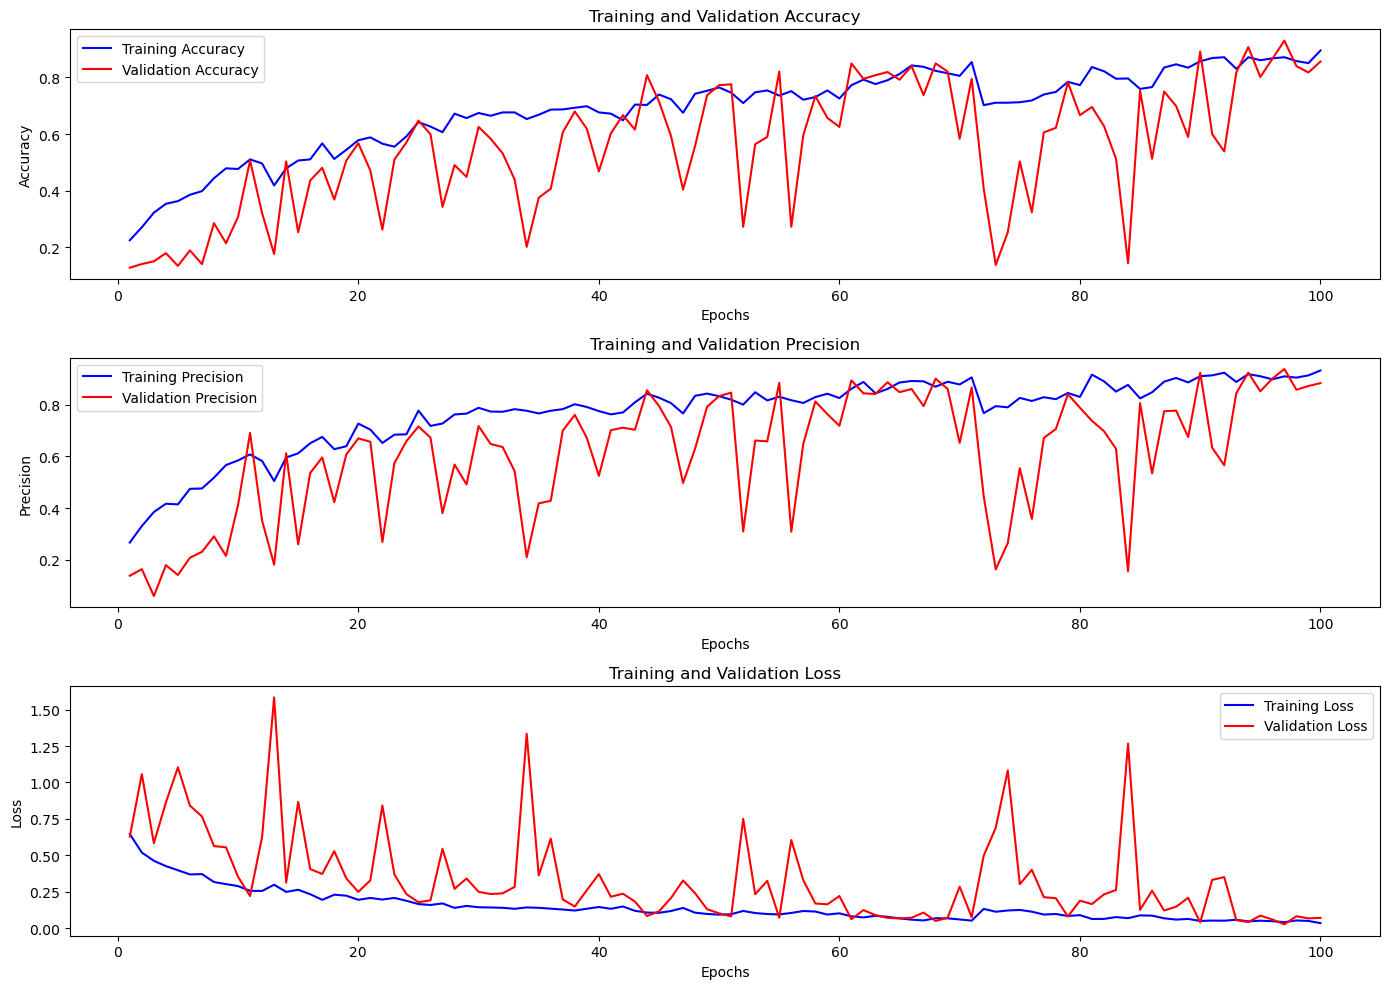

In [13]:
plot_training_metrics(history, save_path='training_metrics_7-12-2024_attempt_6.jpg')

In [14]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 112, 112, 32)        │           1,568 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 112, 112, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 111, 111, 64)        │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 111, 111, 64)        │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 55, 55, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 28, 28, 64)          │         102,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 28, 28, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 26, 26, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 26, 26, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 13, 13, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 13, 13, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 13, 13, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 13, 13, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (None, 13, 13, 512)         │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 6, 6, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 18432)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │       9,437,696 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_6                │ (None, 512)                 │           2,048 │
│ (BatchNormalization)                 │                             │              

 Total params: 34,114,426 (130.14 MB)

 Trainable params: 11,370,088 (43.37 MB)

 Non-trainable params: 4,160 (16.25 KB)

 Optimizer params: 22,740,178 (86.75 MB)